In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
image_path= "/Users/kcl759/Downloads/fer2013.csv"
df = pd.read_csv(image_path)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.count()

emotion    35887
pixels     35887
Usage      35887
dtype: int64

In [4]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [6]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [7]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [8]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [9]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [10]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

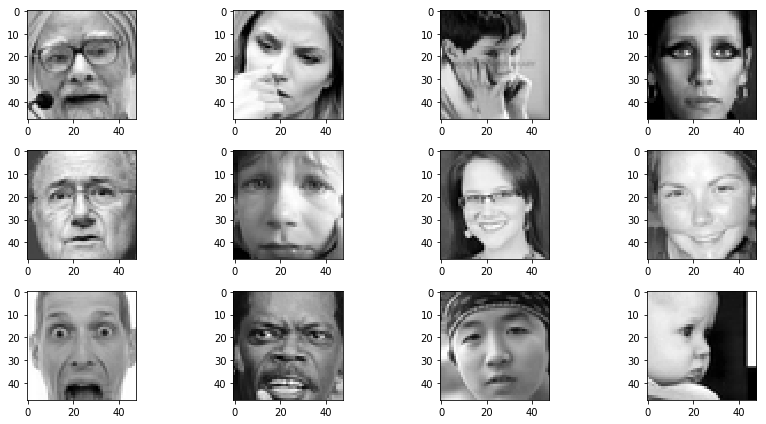

In [14]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
model = Sequential()

model.add(Conv2D(32, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))


model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
activation_2 (Activat

In [12]:

# save best weights
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 10

# run model
hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)


Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
 - 252s - loss: 1.9266 - acc: 0.2804 - val_loss: 1.5892 - val_acc: 0.3951

Epoch 00001: val_loss improved from inf to 1.58922, saving model to face_model.h5
Epoch 2/10
 - 247s - loss: 1.6204 - acc: 0.3673 - val_loss: 1.5166 - val_acc: 0.4140

Epoch 00002: val_loss improved from 1.58922 to 1.51662, saving model to face_model.h5
Epoch 3/10
 - 252s - loss: 1.5213 - acc: 0.4106 - val_loss: 1.4726 - val_acc: 0.4241

Epoch 00003: val_loss improved from 1.51662 to 1.47265, saving model to face_model.h5
Epoch 4/10
 - 256s - loss: 1.4691 - acc: 0.4323 - val_loss: 1.3879 - val_acc: 0.4628

Epoch 00004: val_loss improved from 1.47265 to 1.38787, saving model to face_model.h5
Epoch 5/10
 - 267s - loss: 1.4147 - acc: 0.4519 - val_loss: 1.4191 - val_acc: 0.4525

Epoch 00005: val_loss did not improve from 1.38787
Epoch 6/10
 - 265s - loss: 1.3814 - acc: 0.4669 - val_loss: 1.3764 - val_acc: 0.47

In [13]:

# save best weights
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 30

# run model
hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
 - 264s - loss: 1.2681 - acc: 0.5154 - val_loss: 1.2053 - val_acc: 0.5369

Epoch 00001: val_loss improved from inf to 1.20530, saving model to face_model.h5
Epoch 2/30
 - 260s - loss: 1.2616 - acc: 0.5163 - val_loss: 1.1882 - val_acc: 0.5433

Epoch 00002: val_loss improved from 1.20530 to 1.18825, saving model to face_model.h5
Epoch 3/30
 - 265s - loss: 1.2379 - acc: 0.5249 - val_loss: 1.1788 - val_acc: 0.5536

Epoch 00003: val_loss improved from 1.18825 to 1.17878, saving model to face_model.h5
Epoch 4/30
 - 261s - loss: 1.2215 - acc: 0.5311 - val_loss: 1.1859 - val_acc: 0.5450

Epoch 00004: val_loss did not improve from 1.17878
Epoch 5/30
 - 271s - loss: 1.2095 - acc: 0.5401 - val_loss: 1.1742 - val_acc: 0.5539

Epoch 00005: val_loss improved from 1.17878 to 1.17417, saving model to face_model.h5
Epoch 6/30
 - 270s - loss: 1.2003 - acc: 0.5428 - val_loss: 1.1559 - val_acc: 0.5556

Epoch 00006: val_loss improved from 1.17417 